In [1]:
from pandas import DataFrame, read_excel
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
#IMPORT MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.binary):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Loading data

In [2]:
#read training and test data
p4jtraining = pd.DataFrame()
addtraining = pd.DataFrame()
s4rtraining = pd.DataFrame()
p4jtest = pd.DataFrame()
addtest = pd.DataFrame()
s4rtest = pd.DataFrame()

P4J_training_list= ["./data/CodeTrain10302.csv"]
ADD_training_list= ["./data/PatternsTrain10302.csv"]
S4R_training_list= ["./data/ContextTrain10302.csv"]

P4J_testing_list= ["./data/CodePatchSim.csv"]
ADD_testing_list= ["./data/PatternsPatchSim.csv"]
S4R_testing_list= ["./data/ContextPatchSim.csv"]

In [3]:
for f in P4J_training_list:
    data = pd.read_csv(f, encoding='latin1',index_col=False)
    p4jtraining = p4jtraining.append(data, ignore_index=True)
    
for f in ADD_training_list:
    data = pd.read_csv(f, encoding='latin1',index_col=False)
    addtraining = addtraining.append(data, ignore_index=True)
    
    
for f in S4R_training_list:
    data = pd.read_csv(f, encoding='latin1',index_col=False)
    s4rtraining = s4rtraining.append(data, ignore_index=True)    
    
    
p4jtraining=p4jtraining.iloc[:,:152]
addtraining=addtraining.iloc[:,:28]
s4rtest=s4rtest.iloc[:,:28]
p4jtraining=p4jtraining.drop(columns='label')
s4rtraining=s4rtraining.drop(columns='label')
totaltraining = addtraining.merge(p4jtraining, on="id").merge(s4rtraining, on="id")  
totaltraining.shape

(10302, 204)

In [4]:
for f in P4J_testing_list:
    data = pd.read_csv(f, encoding='latin1',index_col=False)
    p4jtest = p4jtest.append(data, ignore_index=True)
    
for f in ADD_testing_list:
    data = pd.read_csv(f, encoding='latin1',index_col=False)
    addtest = addtest.append(data, ignore_index=True)
    
for f in S4R_testing_list:
    data = pd.read_csv(f, encoding='latin1',index_col=False)
    s4rtest = s4rtest.append(data, ignore_index=True)    
    
    
print(p4jtest.shape)
print(addtest.shape)
print(s4rtest.shape)


p4jtest=p4jtest.iloc[:,:152]
addtest=addtest.iloc[:,:28]
s4rtest=s4rtest.iloc[:,:28]
p4jtest=p4jtest.drop(columns='label')
s4rtest=s4rtest.drop(columns='label')
print('p4jtest: ',p4jtest.shape)
print('addtest: ',addtest.shape)
print('s4rtest: ',s4rtest.shape)
totaltest = addtest.merge(p4jtest, on="id").merge(s4rtest, on="id")  
totaltest.shape

(139, 157)
(139, 29)
(139, 28)
p4jtest:  (139, 151)
addtest:  (139, 28)
s4rtest:  (139, 27)


(139, 204)

In [5]:
test =  totaltest[ totaltest['id'].str.contains(r'Chart')  ]
training= totaltraining[ ~ totaltraining['id'].str.contains(r'Chart') ]
print(test.shape)
print(training.shape)

(26, 204)
(8955, 204)


In [6]:
#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about validation samples
# overfittinginValidation = validation[validation['label']==1]
# correctinValidation=validation[validation['label']==0]
# print("Total validation: ", validation.shape)
# print("overfitting in train",overfittinginValidation.shape)
# print("correct in train",correctinValidation.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)

Total train:  (8955, 204)
overfitting in train (6977, 204)
correct in train (1978, 204)
Total test:  (26, 204)
overfitting in test (23, 204)
correct in test (3, 204)


In [7]:
# Outlier detection 
from collections import Counter

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers  


numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows


,id,label,wrapsLoop,wrapsTryCatch,wrapsIfElse,wrongMethodRef,constChange,unwrapIfElse,unwrapTryCatch,expArithMod,...,similarObjectTypeWithNullGuard,typeOfFaultyStmt,fieldNotAssigned,fieldNotUsed,similarPrimitiveTypeWithNormalGuard,similarPrimitiveTypeWithNullGuard,methodThrowsException,objectUsedInAssignment,primitiveUsedInAssignment,methodCallWithNormalGuard
5498,Closure_163,0,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,...,0,While,0,0,0,0,0,0,0.0,0.0
5506,Closure_103,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,Switch,0,0,0,0,0,0,0.0,0.0
5519,Jsou_52,0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0,If,0,0,0,0,0,0,0.0,0.0
5556,Compress_29,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,Field,0,0,0,0,0,0,0.0,0.0
5562,Math_78,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,If,0,0,0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2168,GenProg_patch_Defects4J_Math_8_0_240,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,LocalVariable,0,0,0,0,1,0,0.0,0.0
2620,GenProg_patch_Defects4J_Math_50_0_83,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,While,0,0,0,0,0,0,0.0,0.0
2944,Arja_patch_Defects4J_Math_81_0_321,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,Assignment,0,0,0,0,0,0,0.0,0.0
3708,Arja_patch_Defects4J_Math_81_0_136,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,If,0,0,0,0,0,0,0.0,0.0


In [8]:
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [9]:
# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]


# process category features

In [10]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
print(headers)
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)

X_train.head(2)

Index(['wrapsLoop', 'wrapsTryCatch', 'wrapsIfElse', 'wrongMethodRef',
       'constChange', 'unwrapIfElse', 'unwrapTryCatch', 'expArithMod',
       'codeMove', 'expLogicExpand',
       ...
       'typeOfFaultyStmt_ NewClass', 'typeOfFaultyStmt_ OperatorAssignment',
       'typeOfFaultyStmt_ Parameter', 'typeOfFaultyStmt_ Return',
       'typeOfFaultyStmt_ Switch', 'typeOfFaultyStmt_ Throw',
       'typeOfFaultyStmt_ Try', 'typeOfFaultyStmt_ TypeReference',
       'typeOfFaultyStmt_ UnaryOperator', 'typeOfFaultyStmt_ While'],
      dtype='object', length=449)


,wrapsLoop,wrapsTryCatch,wrapsIfElse,wrongMethodRef,constChange,unwrapIfElse,unwrapTryCatch,expArithMod,codeMove,expLogicExpand,...,typeOfFaultyStmt_ NewClass,typeOfFaultyStmt_ OperatorAssignment,typeOfFaultyStmt_ Parameter,typeOfFaultyStmt_ Return,typeOfFaultyStmt_ Switch,typeOfFaultyStmt_ Throw,typeOfFaultyStmt_ Try,typeOfFaultyStmt_ TypeReference,typeOfFaultyStmt_ UnaryOperator,typeOfFaultyStmt_ While
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)

In [12]:
PCAmodel = PCA(n_components=6, random_state=42)
X_train_PCA = PCAmodel.fit_transform(X_train.values)
X_test_PAC = PCAmodel.fit_transform(X_test.values)

X_train=X_train_PCA
X_test = X_test_PAC

# Shuffle the training and test data

In [13]:
from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train, random_state=0)

[0]	validation_0-map:0.85680
Will train until validation_0-map hasn't improved in 10 rounds.
[1]	validation_0-map:0.91708
[2]	validation_0-map:0.92108
[3]	validation_0-map:0.94918
[4]	validation_0-map:0.95313
[5]	validation_0-map:0.96454
[6]	validation_0-map:0.95958
[7]	validation_0-map:0.96776
[8]	validation_0-map:0.96947
[9]	validation_0-map:0.96204
[10]	validation_0-map:0.95914
[11]	validation_0-map:0.95432
[12]	validation_0-map:0.95066
[13]	validation_0-map:0.95066
[14]	validation_0-map:0.95667
[15]	validation_0-map:0.95939
[16]	validation_0-map:0.95939
[17]	validation_0-map:0.95667
[18]	validation_0-map:0.95439
Stopping. Best iteration:
[8]	validation_0-map:0.96947

f1 score: 0.7567567567567568
acc score: 0.6538461538461539
precision score: 1.0
recall score: 0.6086956521739131


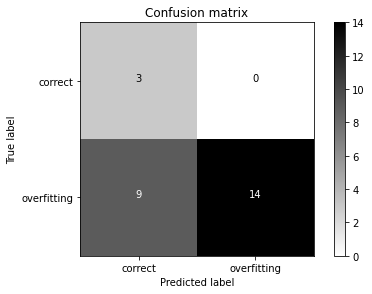

In [14]:
import xgboost as xgb
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

model = xgb.XGBClassifier(random_state=42, max_depth=6,gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=10, eval_metric="map", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)

# Plot non-normalized confusion matrix
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()  


In [15]:
d={'patch':test_file_name,'groundtruth':Y_test,'label':Y_pred}
fn3 = pd.DataFrame(d)
fn3.to_csv('./data/PatchSimODSChart.csv')
print(fn3.head(30))

                patch  groundtruth  label
5       Patch3Chart_3            1      1
8    Patch189Chart_19            0      0
10   Patch188Chart_14            0      0
28      Patch7Chart_5            0      0
32    Patch17Chart_25            1      1
33     Patch9Chart_13            1      0
35    Patch10Chart_13            1      0
42      Patch1Chart_1            1      1
45    Patch16Chart_25            1      0
49    Patch90Chart_17            1      1
50      Patch5Chart_5            1      0
53    Patch11Chart_13            1      1
57    Patch19Chart_26            1      1
59      Patch6Chart_5            1      0
61    Patch92Chart_25            1      1
66      Patch2Chart_1            1      1
68    Patch14Chart_21            1      1
69    Patch18Chart_26            1      1
72      Patch8Chart_7            1      1
90    Patch13Chart_15            1      0
94    Patch93Chart_26            1      1
97    Patch12Chart_15            1      0
122     Patch4Chart_3            1

# PatchSim Repoducible labels:

|patchid|project|bug|groundtruth|patchsim-label|
|--|--|--|--|--|
Patch1|Chart|1|Incorrect|Incorrect
Patch2|Chart|1|Incorrect|Incorrect
Patch4|Chart|3|Incorrect|Incorrect
Patch5|Chart|5|Incorrect|Incorrect
Patch6|Chart|5|Incorrect|Incorrect
Patch7|Chart|5|Correct|Correct
Patch8|Chart|7|Incorrect|Incorrect
Patch9|Chart|13|Incorrect|Incorrect
Patch10|Chart|13|Incorrect|Correct
Patch11|Chart|13|Incorrect|Correct
Patch12|Chart|15|Incorrect|Incorrect
Patch13|Chart|15|Incorrect|Incorrect
Patch14|Chart|21|Incorrect|Correct
Patch15|Chart|25|Incorrect|Incorrect
Patch16|Chart|25|Incorrect|Incorrect
Patch17|Chart|25|Incorrect|Incorrect
Patch18|Chart|26|Incorrect|
Patch19|Chart|26|Incorrect|Incorrect
Patch88|Chart|9|Incorrect|Correct
Patch89|Chart|13|Incorrect|Correct
Patch90|Chart|17|Incorrect|Correct
Patch91|Chart|21|Incorrect|Correct
Patch92|Chart|25|Incorrect|Incorrect
Patch93|Chart|26|Incorrect|
Patch188|Chart|14|Correct|Correct
Patch189|Chart|19|Correct|Correct

# Testing on Lang

In [16]:
test = totaltest[ totaltest['id'].str.contains(r'Lang') ]
training= totaltraining[~ totaltraining['id'].str.contains(r'Lang')]
print(test.shape)
print(training.shape)

#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)

(15, 204)
(9207, 204)
Total train:  (9207, 204)
overfitting in train (7267, 204)
correct in train (1940, 204)
Total test:  (15, 204)
overfitting in test (11, 204)
correct in test (4, 204)


In [17]:
numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [18]:
# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
print(headers)
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)

X_train.head(2)

Index(['wrapsLoop', 'wrapsTryCatch', 'wrapsIfElse', 'wrongMethodRef',
       'constChange', 'unwrapIfElse', 'unwrapTryCatch', 'expArithMod',
       'codeMove', 'expLogicExpand',
       ...
       'typeOfFaultyStmt_ NewArray', 'typeOfFaultyStmt_ NewClass',
       'typeOfFaultyStmt_ OperatorAssignment', 'typeOfFaultyStmt_ Parameter',
       'typeOfFaultyStmt_ Return', 'typeOfFaultyStmt_ Switch',
       'typeOfFaultyStmt_ Throw', 'typeOfFaultyStmt_ Try',
       'typeOfFaultyStmt_ TypeReference', 'typeOfFaultyStmt_ While'],
      dtype='object', length=445)


,wrapsLoop,wrapsTryCatch,wrapsIfElse,wrongMethodRef,constChange,unwrapIfElse,unwrapTryCatch,expArithMod,codeMove,expLogicExpand,...,typeOfFaultyStmt_ NewArray,typeOfFaultyStmt_ NewClass,typeOfFaultyStmt_ OperatorAssignment,typeOfFaultyStmt_ Parameter,typeOfFaultyStmt_ Return,typeOfFaultyStmt_ Switch,typeOfFaultyStmt_ Throw,typeOfFaultyStmt_ Try,typeOfFaultyStmt_ TypeReference,typeOfFaultyStmt_ While
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[0]	validation_0-map:0.88014
Will train until validation_0-map hasn't improved in 10 rounds.
[1]	validation_0-map:0.92737
[2]	validation_0-map:0.95360
[3]	validation_0-map:0.99242
[4]	validation_0-map:0.99242
[5]	validation_0-map:0.99242
[6]	validation_0-map:0.99242
[7]	validation_0-map:0.99242
[8]	validation_0-map:0.99242
[9]	validation_0-map:0.99242
[10]	validation_0-map:0.99242
[11]	validation_0-map:1.00000
[12]	validation_0-map:1.00000
[13]	validation_0-map:1.00000
[14]	validation_0-map:1.00000
[15]	validation_0-map:0.99242
[16]	validation_0-map:0.99242
[17]	validation_0-map:0.99242
[18]	validation_0-map:0.98052
[19]	validation_0-map:0.98601
[20]	validation_0-map:0.99242
[21]	validation_0-map:0.99242
Stopping. Best iteration:
[11]	validation_0-map:1.00000

f1 score: 0.9523809523809523
acc score: 0.9333333333333333
precision score: 1.0
recall score: 0.9090909090909091


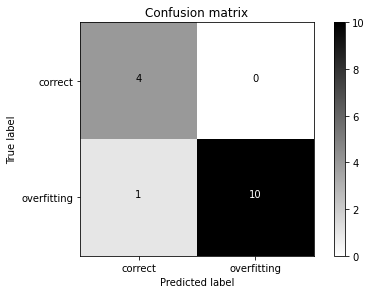

In [19]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)

PCAmodel = PCA(n_components=6, random_state=42)
X_train_PCA = PCAmodel.fit_transform(X_train.values)
X_test_PAC = PCAmodel.fit_transform(X_test.values)

X_train=X_train_PCA
X_test = X_test_PAC


from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


import xgboost as xgb
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

model = xgb.XGBClassifier(random_state=42, max_depth=6,gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=10, eval_metric="map", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)

# Plot non-normalized confusion matrix
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()  

In [20]:
d={'patch':test_file_name,'groundtruth':Y_test,'label':Y_pred}
fn3 = pd.DataFrame(d)
fn3.to_csv('./data/PatchSimODSLang.csv')
print(fn3.head(30))

                    patch  groundtruth  label
7          Patch190Lang_7            0      0
9         Patch191Lang_24            0      0
13        Patch193Lang_39            1      1
18         Patch21Lang_44            0      0
52         Patch22Lang_46            1      1
54   PatchHDRepair2Lang_6            1      1
56        Patch192Lang_35            1      0
70        Patch152Lang_53            1      1
77         Patch20Lang_39            1      1
86         Patch24Lang_53            1      1
95        Patch150Lang_44            1      1
100       Patch153Lang_58            1      1
107        Patch23Lang_51            1      1
117       Patch151Lang_51            1      1
128        Patch25Lang_55            0      0


# patchsim labels

|patchid|project|bug|groundtruth|patchsim-label|
|--|--|--|--|--|
Patch20|Lang|39|Incorrect|
Patch21|Lang|44|Correct|Correct
Patch22|Lang|46|Incorrect|Incorrect
Patch23|Lang|51|Incorrect|Incorrect
Patch24|Lang|53|Incorrect|Correct
Patch25|Lang|55|Correct|Correct
Patch26|Lang|58|Correct|Correct
Patch150|Lang|44|Incorrect|Incorrect
Patch151|Lang|51|Incorrect|Incorrect
Patch152|Lang|53|Incorrect|Correct
Patch153|Lang|58|Incorrect|Incorrect
Patch191|Lang|24|Correct|Correct
Patch192|Lang|35|Correct|
Patch193|Lang|39|Incorrect|Incorrect
PatchHDRepair1|Lang|57|Incorrect|Correct

# Testing on Math

In [21]:
test = totaltest[ totaltest['id'].str.contains(r'Math') ]
training= totaltraining[~ totaltraining['id'].str.contains(r'Math') ]
print(test.shape)
print(training.shape)

#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)

(83, 204)
(5522, 204)
Total train:  (5522, 204)
overfitting in train (3625, 204)
correct in train (1897, 204)
Total test:  (83, 204)
overfitting in test (63, 204)
correct in test (20, 204)


Index(['wrapsLoop', 'wrapsTryCatch', 'wrapsIfElse', 'wrongMethodRef',
       'constChange', 'unwrapIfElse', 'unwrapTryCatch', 'expArithMod',
       'codeMove', 'expLogicExpand',
       ...
       'typeOfFaultyStmt_ NewClass', 'typeOfFaultyStmt_ OperatorAssignment',
       'typeOfFaultyStmt_ Parameter', 'typeOfFaultyStmt_ Return',
       'typeOfFaultyStmt_ Switch', 'typeOfFaultyStmt_ Throw',
       'typeOfFaultyStmt_ Try', 'typeOfFaultyStmt_ TypeReference',
       'typeOfFaultyStmt_ UnaryOperator', 'typeOfFaultyStmt_ While'],
      dtype='object', length=443)
[0]	validation_0-map:0.83650
Will train until validation_0-map hasn't improved in 10 rounds.
[1]	validation_0-map:0.86318
[2]	validation_0-map:0.86520
[3]	validation_0-map:0.87533
[4]	validation_0-map:0.86413
[5]	validation_0-map:0.86838
[6]	validation_0-map:0.85694
[7]	validation_0-map:0.84965
[8]	validation_0-map:0.86124
[9]	validation_0-map:0.85978
[10]	validation_0-map:0.84591
[11]	validation_0-map:0.84650
[12]	validation_0-map

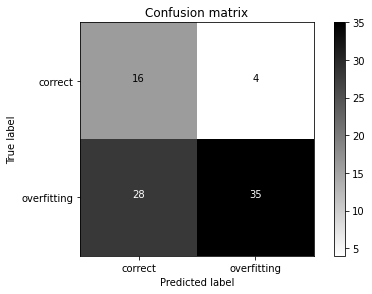

In [22]:
numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
print(headers)
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)

X_train.head(2)

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)

PCAmodel = PCA(n_components=6, random_state=42)
X_train_PCA = PCAmodel.fit_transform(X_train.values)
X_test_PAC = PCAmodel.fit_transform(X_test.values)

X_train=X_train_PCA
X_test = X_test_PAC


from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


import xgboost as xgb
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

model = xgb.XGBClassifier(random_state=42, max_depth=6,gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=10, eval_metric="map", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)

# Plot non-normalized confusion matrix
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()  


In [23]:
d={'patch':test_file_name,'groundtruth':Y_test,'label':Y_pred}
fn3 = pd.DataFrame(d)
fn3.to_csv('./data/PatchSimODSMath.csv')
print(fn3.head(50))
print(fn3.tail(33))

                    patch  groundtruth  label
0          Patch196Math_5            0      0
1          Patch45Math_50            0      0
2          Patch194Math_3            0      0
3          Patch47Math_53            0      0
4         Patch209Math_99            0      0
6   PatchHDRepair7Math_70            0      1
11        Patch205Math_89            0      0
12        Patch199Math_35            0      0
14         Patch46Math_50            0      0
15         Patch54Math_73            0      1
16        Patch203Math_82            0      0
17          Patch29Math_5            0      0
19        Patch207Math_93            0      0
20  PatchHDRepair4Math_34            0      0
21         Patch51Math_70            0      1
22         Patch44Math_50            0      0
23        Patch206Math_90            0      0
25        Patch197Math_25            0      0
26         Patch195Math_4            0      0
27        Patch204Math_85            0      1
30         Patch42Math_49         

# PatchSim Repoducible labels:

|patchid|project|bug|groundtruth|patchsim-label|
|--|--|--|--|--|
Patch27|Math|2|Incorrect|Incorrect
Patch28|Math|2|Incorrect|Incorrect
Patch29|Math|5|Correct|Correct
Patch30|Math|8|Incorrect|Correct
Patch31|Math|8|Incorrect|Correct
Patch32|Math|28|Incorrect|Incorrect
Patch33|Math|28|Incorrect|Incorrect
Patch34|Math|32|Incorrect|Correct
Patch36|Math|33|Incorrect|Correct
Patch37|Math|40|Incorrect|Correct
Patch38|Math|40|Incorrect|Incorrect
Patch44|Math|50|Correct|Correct
Patch45|Math|50|Correct|Correct
Patch46|Math|50|Correct|Correct
Patch47|Math|53|Correct|Correct
Patch48|Math|57|Incorrect|Incorrect
Patch49|Math|58|Incorrect|Incorrect
Patch51|Math|70|Correct|Correct
Patch53|Math|71|Incorrect|Correct
Patch54|Math|73|Correct|Correct
Patch55|Math|73|Incorrect|Correct
Patch58|Math|78|Incorrect|Correct
Patch59|Math|80|Incorrect|Correct
Patch62|Math|81|Incorrect|Incorrect
Patch63|Math|81|Incorrect|Correct
Patch64|Math|81|Incorrect|Correct
Patch65|Math|82|Incorrect|Incorrect
Patch66|Math|82|Incorrect|Incorrect
Patch67|Math|82|Incorrect|Incorrect
Patch68|Math|84|Incorrect|Incorrect
Patch69|Math|84|Incorrect|Incorrect
Patch72|Math|85|Incorrect|Incorrect
Patch73|Math|87|Incorrect|Correct
Patch74|Math|88|Incorrect|Incorrect
Patch75|Math|95|Incorrect|Correct
Patch76|Math|95|Incorrect|Correct
Patch77|Math|97|Incorrect|Correct
Patch78|Math|104|Incorrect|Incorrect
Patch79|Math|105|Incorrect|Correct
Patch154|Math|2|Incorrect|Incorrect
Patch155|Math|4|Incorrect|Correct
Patch157|Math|24|Incorrect|Incorrect
Patch158|Math|28|Incorrect|Incorrect
Patch159|Math|33|Incorrect|Incorrect
Patch160|Math|39|Incorrect|Incorrect
Patch161|Math|40|Incorrect|Correct
Patch162|Math|41|Incorrect|Correct
Patch163|Math|42|Incorrect|Correct
Patch165|Math|49|Incorrect|Correct
Patch166|Math|50|Incorrect|Correct
Patch167|Math|57|Incorrect|Incorrect
Patch168|Math|58|Incorrect|Correct
Patch169|Math|69|Incorrect|Incorrect
Patch170|Math|73|Incorrect|Correct
Patch171|Math|78|Incorrect|Correct
Patch172|Math|80|Incorrect|Correct
Patch173|Math|81|Incorrect|Correct
Patch174|Math|85|Incorrect|Incorrect
Patch175|Math|87|Incorrect|Incorrect
Patch176|Math|88|Incorrect|Incorrect
Patch177|Math|105|Incorrect|Incorrect
Patch194|Math|3|Correct|Correct
Patch195|Math|4|Correct|Correct
Patch196|Math|5|Correct|Correct
Patch197|Math|25|Correct|Correct
Patch198|Math|28|Incorrect|Incorrect
Patch199|Math|35|Correct|Correct
Patch201|Math|73|Incorrect|Incorrect
Patch202|Math|81|Incorrect|Correct
Patch203|Math|82|Correct|Correct
Patch204|Math|85|Correct|Correct
Patch205|Math|89|Correct|Correct
Patch206|Math|90|Correct|Correct
Patch207|Math|93|Correct|Correct
Patch208|Math|97|Incorrect|Incorrect
Patch209|Math|99|Correct|Correct
PatchHDRepair3|Math|22|Incorrect|Correct
PatchHDRepair4|Math|34|Correct|Correct
PatchHDRepair5|Math|50|Incorrect|Correct
PatchHDRepair6|Math|53|Incorrect|Incorrect
PatchHDRepair7|Math|70|Correct|Correct
PatchHDRepair8|Math|82|Incorrect|Incorrect
PatchHDRepair9|Math|85|Incorrect|Incorrect

# Testing on Time

In [24]:
test = totaltest[ totaltest['id'].str.contains(r'Time') ]
training= totaltraining[~ totaltraining['id'].str.contains(r'Time') ]
print(test.shape)
print(training.shape)

#statistics about training samples
overfittingintrain = training[training['label']==1]
correctintrain=training[training['label']==0]
print("Total train: ", training.shape)
print("overfitting in train",overfittingintrain.shape)
print("correct in train",correctintrain.shape)
print("====================")
#statistics about test samples
overfittingintest = test[test['label']==1]
correctintest=test[test['label']==0]
print("Total test: ",test.shape)
print("overfitting in test",overfittingintest.shape)
print("correct in test",correctintest.shape)

(15, 204)
(10273, 204)
Total train:  (10273, 204)
overfitting in train (8299, 204)
correct in train (1974, 204)
Total test:  (15, 204)
overfitting in test (13, 204)
correct in test (2, 204)


Index(['wrapsLoop', 'wrapsTryCatch', 'wrapsIfElse', 'wrongMethodRef',
       'constChange', 'unwrapIfElse', 'unwrapTryCatch', 'expArithMod',
       'codeMove', 'expLogicExpand',
       ...
       'typeOfFaultyStmt_ NewArray', 'typeOfFaultyStmt_ OperatorAssignment',
       'typeOfFaultyStmt_ Parameter', 'typeOfFaultyStmt_ Return',
       'typeOfFaultyStmt_ Switch', 'typeOfFaultyStmt_ Throw',
       'typeOfFaultyStmt_ Try', 'typeOfFaultyStmt_ TypeReference',
       'typeOfFaultyStmt_ UnaryOperator', 'typeOfFaultyStmt_ While'],
      dtype='object', length=448)
[0]	validation_0-map:0.97042
Will train until validation_0-map hasn't improved in 10 rounds.
[1]	validation_0-map:0.97042
[2]	validation_0-map:0.96273
[3]	validation_0-map:0.96273
[4]	validation_0-map:0.96273
[5]	validation_0-map:0.97042
[6]	validation_0-map:0.97518
[7]	validation_0-map:0.96749
[8]	validation_0-map:0.96749
[9]	validation_0-map:0.96273
[10]	validation_0-map:0.95418
[11]	validation_0-map:0.95895
[12]	validation_0-map

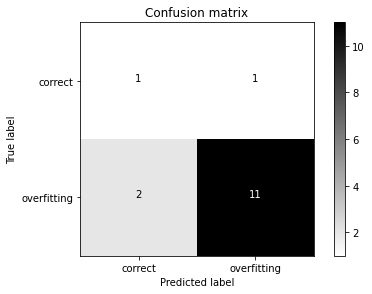

In [25]:
numerical_features = training.select_dtypes(include=np.number).columns.tolist()
Outliers_to_drop = detect_outliers(training,15,numerical_features)
training.loc[Outliers_to_drop] # Show the outliers rows
training = training.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


# 202 features
test_file_name = test.iloc[:,0]
X_train = training.iloc[:,2:]
Y_train = training.iloc[:,1]
X_test = test.iloc[:,2:]
Y_test = test.iloc[:,1]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train,X_test=X_train.align(X_test,join='left',axis=1)
X_train.head(2)
X_test.head(2)
headers = X_train.columns
print(headers)
training.isnull().sum()
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train,columns=headers)
X_test = pd.DataFrame(X_test,columns=headers)

X_train.head(2)

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
smote = SMOTE(random_state=42,sampling_strategy='minority')
X_train, Y_train = smote.fit_sample(X_train, Y_train)

PCAmodel = PCA(n_components=6, random_state=42)
X_train_PCA = PCAmodel.fit_transform(X_train.values)
X_test_PAC = PCAmodel.fit_transform(X_test.values)

X_train=X_train_PCA
X_test = X_test_PAC


from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


import xgboost as xgb
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

model = xgb.XGBClassifier(random_state=42, max_depth=6,gamma=0.5)
eval_set=[(X_test,Y_test)]
model.fit(X_train,Y_train, early_stopping_rounds=10, eval_metric="map", eval_set=eval_set)

Y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(Y_test,Y_pred)

f1s = f1_score(Y_test, Y_pred, zero_division=1)
print('f1 score:', f1s)
acc = accuracy_score(Y_test, Y_pred)
print('acc score:', acc)
precisionsc = precision_score(Y_test, Y_pred)
print('precision score:', precisionsc)
recall = recall_score(Y_test, Y_pred)
print('recall score:', recall)

# Plot non-normalized confusion matrix
class_names = ['correct','overfitting']
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()  


In [26]:
d={'patch':test_file_name,'groundtruth':Y_test,'label':Y_pred}
fn3 = pd.DataFrame(d)
fn3.to_csv('./data/PatchSimODSTime.csv')
print(fn3.head(20))

                      patch  groundtruth  label
24          Patch210Time_15            0      0
29   PatchHDRepair10Time_19            0      1
34           Patch83Time_11            1      1
36          Patch182Time_11            1      1
40            Patch80Time_4            1      1
43          Patch186Time_18            1      0
62          Patch183Time_12            1      1
84            Patch81Time_4            1      1
87          Patch185Time_16            1      1
91           Patch181Time_7            1      1
96          Patch187Time_19            1      1
104          Patch82Time_11            1      1
121          Patch180Time_4            1      1
132         Patch184Time_14            1      1
138          Patch84Time_11            1      0


# PatchSim Repoducible labels:

|patchid|project|bug|groundtruth|patchsim-label|
|--|--|--|--|--|
Patch80|Time|4|Incorrect|Incorrect
Patch81|Time|4|Incorrect|Incorrect
Patch82|Time|11|Incorrect|Correct
Patch83|Time|11|Incorrect|Correct
Patch84|Time|11|Incorrect|Correct
Patch180|Time|4|Incorrect|Correct
Patch181|Time|7|Incorrect|Incorrect
Patch182|Time|11|Incorrect|Correct
Patch183|Time|12|Incorrect|Correct
Patch184|Time|14|Incorrect|Incorrect
Patch185|Time|16|Incorrect|Correct
Patch186|Time|18|Incorrect|Incorrect
Patch187|Time|19|Incorrect|Incorrect
Patch210|Time|15|Correct|Correct
PatchHDRepair10|Time|19|Correct|Correct